# Benchmarks for Microgrid environment

The notebook provides testing and comparison between deterministic policies and a pretrained RL agent strategies among the `MicroGridEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from gymnasium.utils.env_checker import check_env
import gymnasium as gym

from gym4real.envs.elevator.utils import parameter_generator

In [68]:
sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.2)

alg_color = OrderedDict({
    'random': plot_colors[0],
    'longest_first': plot_colors[1],
    'shortest_first': plot_colors[2],
    'q-learning': plot_colors[3],
    'sarsa': plot_colors[4],
    'dqn': plot_colors[5]
})

alg_markers = OrderedDict({
    'random': '.',
    'longest_first': 'o',
    'shortest_first': 's',
    'q-learning': 's',
    'sarsa': 's',
    'dqn': '*',
})

alg_labels = {
    'random': 'Random',
    'longest_first': 'LF',
    'shortest_first': 'SF',
    'q-learning': 'Q-Learning',
    'sarsa': 'SARSA',
    'dqn': 'DQN',
}

In [31]:
# IF RESULTS ARE ALREADY AVAILABLE, GO TO LAST CELLS TO LOAD THEM FROM JSON FILE AND DIRECTLY PLOT THEM!!

## Deterministic policies
Here we can evaluate different rule-based and deterministic policies.
Hereafter we will test:
1. random action policy
2. longest-first policy

In [33]:
# Test profiles belonging to the test set
rewards = defaultdict(dict)
eval_episodes = 30

<h3> Random Policy: </h3>
The action is chosen randomly at each decision step.

In [34]:
params = parameter_generator(world_options='gym4real/envs/elevator/world.yaml', seed=1234)
env = gym.make(id="gym4real/elevator-v0", **{'settings':params})

alg = 'random'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset()
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []
    
    while not done:
        action = env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.12it/s]


<h3> Longest First Policy: </h3>
The action chosen is the one that allows for handling the **longest** queue at the moment. However, if some passengers are already inside the elevator, they are served immediately, even if the elevator is not at full capacity.

In [35]:
params = parameter_generator(world_options='gym4real/envs/elevator/world.yaml', seed=1234)
env = gym.make(id="gym4real/elevator-v0", **{'settings':params})

alg = 'longest_first'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset()
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []
    
    while not done:
        if obs['n_passengers'] > 0:
            if obs['current_position'] * info['movement_speed'] / info['floor_height'] == info['goal_floor']:
                action = 1  # stay still
            else:
                action = 0  # move down
        else:
            # Check if any passengers are waiting on the current floor
            len_max_queue, idx_max_queue = max((queue, idx+1) for idx, queue in enumerate(obs['floor_queues']))
            
            if len_max_queue == 0:
                action = 1  # stay still
            else:
                if obs['current_position'] * info['movement_speed'] == (idx_max_queue) * info['floor_height']:
                    action = 1  # stay still
                elif obs['current_position'] * info['movement_speed'] < (idx_max_queue) * info['floor_height']:
                    action = 2  # move up            
                elif obs['current_position'] * info['movement_speed'] > (idx_max_queue) * info['floor_height']:
                    action = 0
                else:
                    action = 1
                    
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.72it/s]


<h3> Shortest First Policy: </h3>
The action chosen is the one that allows for handling the **shortest** queue at the moment. However, if some passengers are already inside the elevator, they are served immediately, even if the elevator is not at full capacity.

In [36]:
params = parameter_generator(world_options='gym4real/envs/elevator/world.yaml', seed=1234)
env = gym.make(id="gym4real/elevator-v0", **{'settings':params})

alg = 'shortest_first'
rewards[alg] = {}

for episode in tqdm(range(eval_episodes)):
    obs, info = env.reset()
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []
    
    while not done:
        if obs['n_passengers'] > 0:
            if obs['current_position'] * info['movement_speed'] / info['floor_height'] == info['goal_floor']:
                action = 1  # stay still
            else:    
                action = 0  # move down
        else:
            # Check if any passengers are waiting on the current floor
            if sum([queue for queue in obs['floor_queues']]) > 0:
                len_min_queue, idx_min_queue = min((queue, idx+1) for idx, queue in enumerate(obs['floor_queues']) if queue > 0)
            
                if obs['current_position'] * info['movement_speed'] == (idx_min_queue) * info['floor_height']:
                    action = 1  # stay still
                elif obs['current_position'] * info['movement_speed'] < (idx_min_queue) * info['floor_height']:
                    action = 2  # move up            
                else: 
                    action = 0  # move down
            else:
                action = 1
                    
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.57it/s]


### Q-Learning
Here we load a custom pre-trained `Q-Learning` model.

In [72]:
import pickle

def default_q_values():
        return np.zeros(3)

def obs_to_key(obs):
    # Manually flatten the dict to a tuple of ints
    return (
        obs['current_position'],
        obs['n_passengers'],
        obs['speed'],
        *obs['floor_queues'],
        *obs['arrivals']
    )

In [73]:
params = parameter_generator(world_options='gym4real/envs/elevator/world.yaml', seed=1234)
env = gym.make(id="gym4real/elevator-v0", **{'settings':params})

alg = 'q-learning'
rewards[alg] = {}
with open('examples/elevator/trained_models/trained_Qtable_qlearning.pkl', 'rb') as f:
    Q = pickle.load(f)

for episode in tqdm(range(eval_episodes)):
    obs, _ = env.reset()
    obs_key = obs_to_key(obs)

    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []
    
    while not done:
        action = np.argmax(Q[obs_key])  # Exploit learned values
        new_obs, reward, terminated, truncated, _ = env.step(action)
        new_obs_key = obs_to_key(new_obs)
        
        cumulated_reward += reward
        done = terminated or truncated
        obs_key = new_obs_key

        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(reward)

  0%|                                                                                                                                                                                                                         | 0/30 [00:00<?, ?it/s]/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:139: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(f"{pre} was expecting a numpy array, actual type: {type(obs)}")
/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:139: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(f"{pre} was expecting a numpy array, actual type: {type(obs)}")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### SARSA

In [74]:
params = parameter_generator(world_options='gym4real/envs/elevator/world.yaml', seed=1234)
env = gym.make(id="gym4real/elevator-v0", **{'settings':params})

alg = 'sarsa'
rewards[alg] = {}
with open('examples/elevator/trained_models/trained_Qtable_sarsa.pkl', 'rb') as f:
    Q = pickle.load(f)

for episode in tqdm(range(eval_episodes)):
    obs, _ = env.reset()
    obs_key = obs_to_key(obs)

    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []
    
    while not done:
        action = np.argmax(Q[obs_key])  # Exploit learned values
        new_obs, reward, terminated, truncated, _ = env.step(action)
        new_obs_key = obs_to_key(new_obs)
        
        cumulated_reward += reward
        done = terminated or truncated
        obs_key = new_obs_key

        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.57it/s]


### DQN agent
Here we load the previously created model `DQN_trained`.

In [37]:
# Uncomment the following line to install stable-baselines3
#!pip install stable-baselines3

In [38]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

In [39]:
env = make_vec_env("gym4real/elevator-v0", n_envs=1, env_kwargs={'settings':params})

alg = 'dqn'
rewards[alg] = {}

model = DQN('MultiInputPolicy', env, verbose=1)
vec_env = model.get_env()
model = DQN.load("examples/elevator/trained_models/DQN_trained")

for episode in tqdm(range(eval_episodes)):
    obs = vec_env.reset()

    done = False
    cumulated_reward = 0
    rewards[alg][episode] = {}
    rewards[alg][episode]['cum'] = []
    rewards[alg][episode]['reward'] = []

    while not done:
        action, _states = model.predict(obs)
        obs, r, dones, info = vec_env.step(action)
        done = dones[0]
        cumulated_reward += r[0]
        rewards[alg][episode]['cum'].append(cumulated_reward)
        rewards[alg][episode]['reward'].append(r[0])

/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


Using cpu device


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.57it/s]


In [40]:
#import json

#with open('examples/microgrid/test_results.json', 'w') as f:
#    json.dump(rewards, f, indent=4)

## Result analysis
Here we compare the average cumulated reward across all the test profiles among the different methods.

In [69]:
#import json

#with open('examples/microgrid/test_results.json', 'r') as f:
#    rewards = json.load(f)

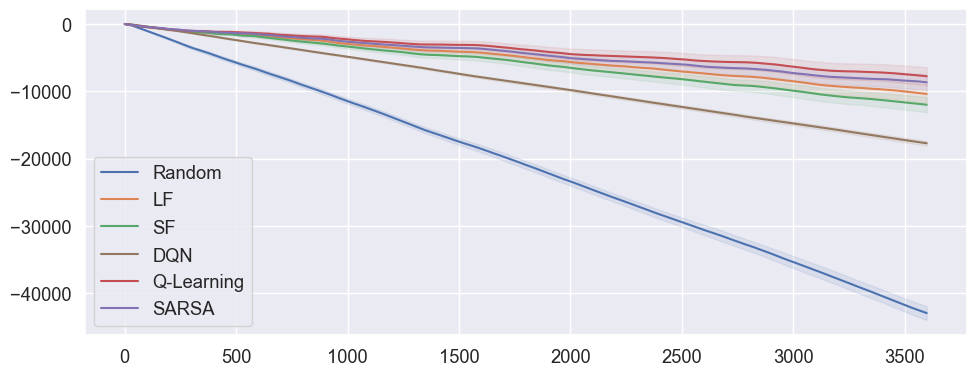

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for i, alg in enumerate(rewards.keys()):
    cum_rewards = [rewards[alg][episode]['cum'] for episode in range(eval_episodes)]
    means = np.mean(cum_rewards, axis=0)
    stds = np.std(cum_rewards, axis=0)
    ci = 1.96 * stds/np.sqrt(len(rewards[alg].keys()))
    
    ax.plot(means, label=alg_labels[alg], color=alg_color[alg])        
    ax.fill_between(range(len(means)), means + ci, means - ci, color=alg_color[alg], alpha=0.1)
    ax.legend()

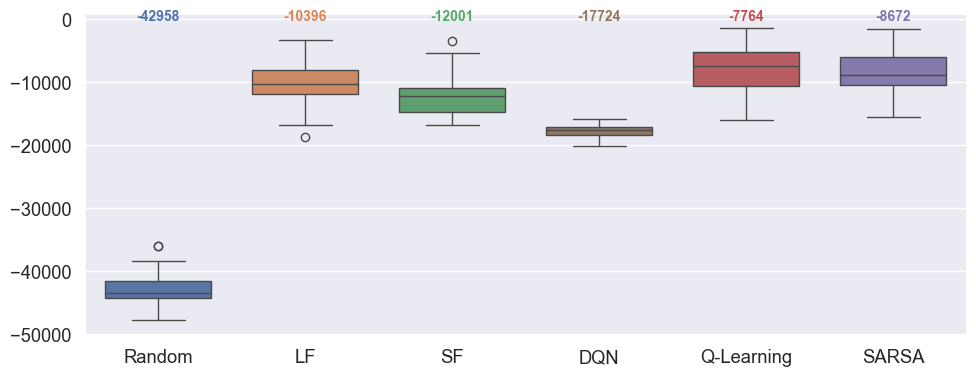

In [76]:
box_data = {}
colors = []

for alg in rewards.keys():
    box_data[alg_labels[alg]] = []
    
    for episode in rewards[alg].keys():
        box_data[alg_labels[alg]].append(rewards[alg][episode]['cum'][-1])

    colors.append(alg_color[alg])
        
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
box_plot = sns.boxplot(box_data, gap=.1, palette=colors, width=0.8)

medians = [np.mean(values) for key, values in box_data.items()]
vertical_offset = -130 # offset from median for display

for xtick, alg in zip(box_plot.get_xticks(), rewards.keys()):
    box_plot.text(xtick, 
                  vertical_offset, 
                  round(medians[xtick]), 
                  horizontalalignment='center',
                  size='x-small', 
                  color=alg_color[alg], 
                  weight='semibold')